In [36]:
#General
import pandas as pd
import numpy as np
import json
import os
import polars as pl
import holidays
import datetime

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore, Style, init;


# Modeling
import xgboost as xgb
import lightgbm as lgb
import torch
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# from sklego.preprocessing import RepeatingBasisFunction


# Geolocation
from geopy.geocoders import Nominatim

# Options
pd.set_option('display.max_columns', 200)

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
import keras


In [37]:
base_dir = "/kaggle/input/predict-energy-behavior-of-prosumers"

In [38]:
train = pd.read_csv(os.path.join(base_dir, 'train.csv'), parse_dates=True)

In [39]:
for i in range(0, 15):
    county = train[train['county']==i]
    print(f'county{i}: {county.shape[0]}')
train = train[train['county']==0]
train = train[train['is_consumption']==1]
train

county0: 212928
county1: 91872
county2: 115200
county3: 122496
county4: 147264
county5: 151632
county6: 30624
county7: 173088
county8: 91872
county9: 122496
county10: 134640
county11: 198000
county12: 30624
county13: 121056
county14: 125808


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
5,0,0,3,656.859,1,2021-09-01 00:00:00,0,5,2
7,0,1,0,59.000,1,2021-09-01 00:00:00,0,7,3
9,0,1,1,501.760,1,2021-09-01 00:00:00,0,9,4
...,...,...,...,...,...,...,...,...,...
2018227,0,0,3,1349.457,1,2023-05-31 23:00:00,637,2018227,2
2018229,0,1,0,540.327,1,2023-05-31 23:00:00,637,2018229,3
2018231,0,1,1,889.251,1,2023-05-31 23:00:00,637,2018231,4
2018233,0,1,2,20.993,1,2023-05-31 23:00:00,637,2018233,61


In [40]:
train = train.groupby(['datetime'])['target'].mean().reset_index()
train

,datetime,target
0,2021-09-01 00:00:00,1081.096500
1,2021-09-01 01:00:00,1031.702667
2,2021-09-01 02:00:00,1023.151333
3,2021-09-01 03:00:00,1000.261500
4,2021-09-01 04:00:00,1025.369333
...,...,...
15307,2023-05-31 19:00:00,1565.585857
15308,2023-05-31 20:00:00,1716.210429
15309,2023-05-31 21:00:00,1768.884857
15310,2023-05-31 22:00:00,1722.416857


In [41]:
dataset = train
dataset["Month"] = pd.to_datetime(dataset["datetime"]).dt.month
dataset["Year"] = pd.to_datetime(dataset["datetime"]).dt.year
dataset["Date"] = pd.to_datetime(dataset["datetime"]).dt.date
dataset["Time"] = pd.to_datetime(dataset["datetime"]).dt.time
dataset["Week"] = pd.to_datetime(dataset["datetime"]).dt.isocalendar().week
dataset["Day"] = pd.to_datetime(dataset["datetime"]).dt.day_name()
dataset = dataset.set_index("datetime")
dataset.index = pd.to_datetime(dataset.index)

In [42]:
dataset.head()

,target,Month,Year,Date,Time,Week,Day
datetime,,,,,,,
2021-09-01 00:00:00,1081.096500,9,2021,2021-09-01,00:00:00,35,Wednesday
2021-09-01 01:00:00,1031.702667,9,2021,2021-09-01,01:00:00,35,Wednesday
2021-09-01 02:00:00,1023.151333,9,2021,2021-09-01,02:00:00,35,Wednesday
2021-09-01 03:00:00,1000.261500,9,2021,2021-09-01,03:00:00,35,Wednesday
2021-09-01 04:00:00,1025.369333,9,2021,2021-09-01,04:00:00,35,Wednesday


In [43]:
print("")
print("Total Number of Years: ", dataset.Year.nunique() )
print(dataset.Year.unique())


Total Number of Years:  3
[2021 2022 2023]


In [44]:
dataset = dataset[121:-72]
dataset.tail()

,target,Month,Year,Date,Time,Week,Day
datetime,,,,,,,
2023-05-28 19:00:00,1310.162714,5,2023,2023-05-28,19:00:00,21,Sunday
2023-05-28 20:00:00,1384.132857,5,2023,2023-05-28,20:00:00,21,Sunday
2023-05-28 21:00:00,1433.445286,5,2023,2023-05-28,21:00:00,21,Sunday
2023-05-28 22:00:00,1466.209429,5,2023,2023-05-28,22:00:00,21,Sunday
2023-05-28 23:00:00,1428.327143,5,2023,2023-05-28,23:00:00,21,Sunday


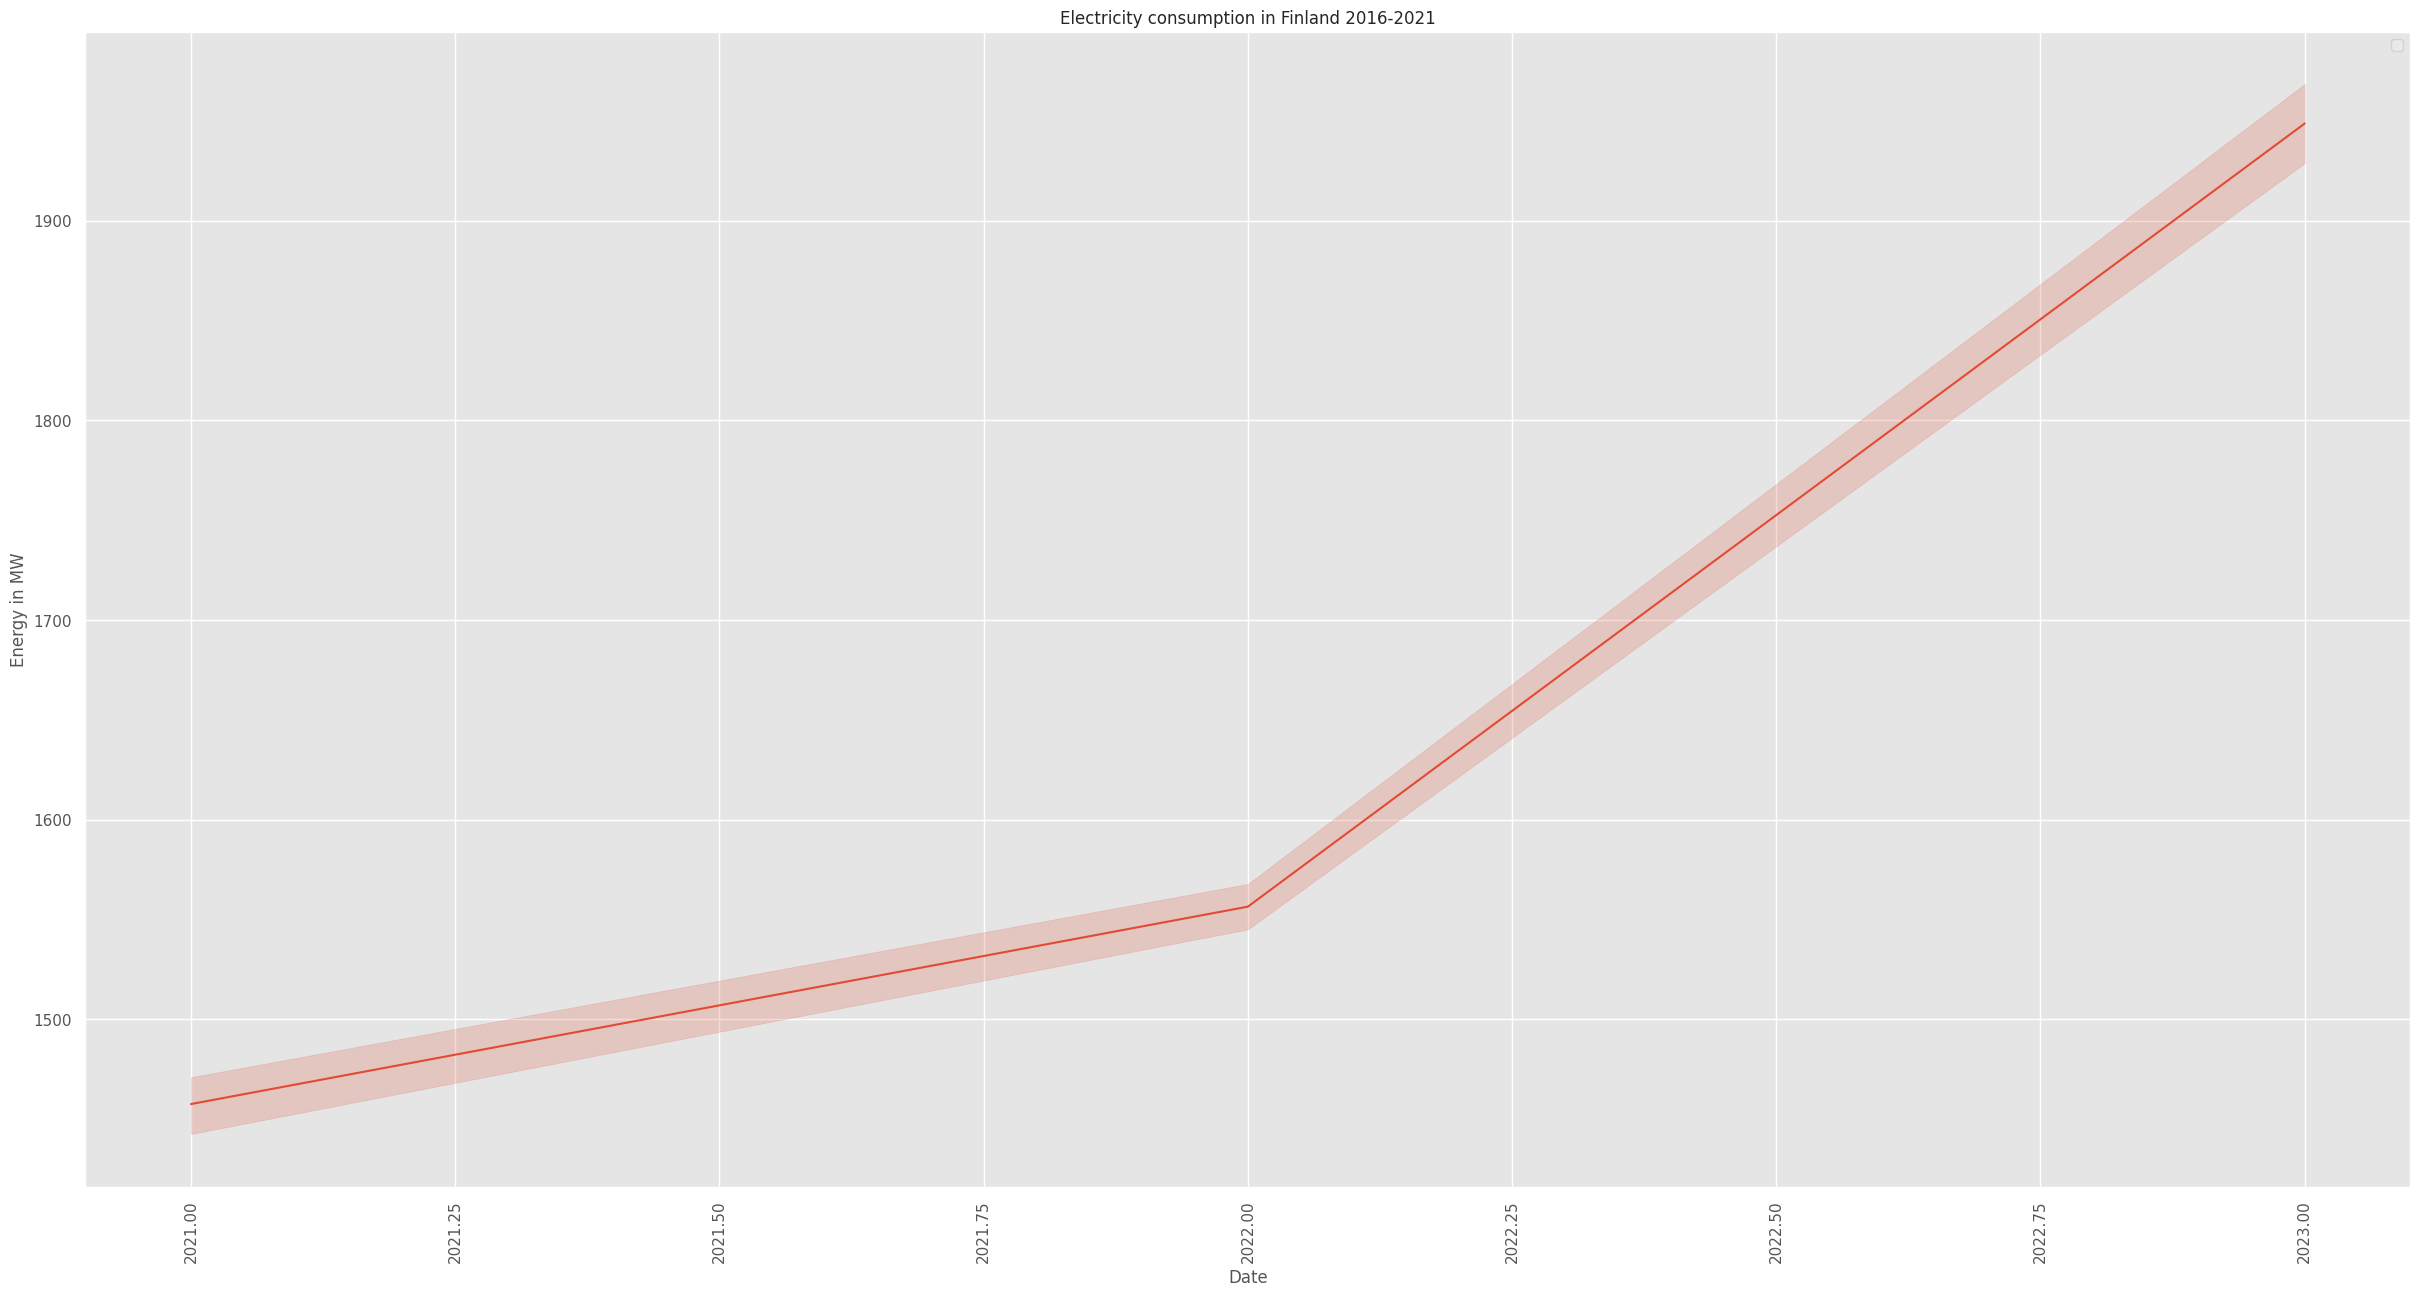

In [45]:
from matplotlib import style
fig = plt.figure()
axes1 = plt.subplot2grid((1,1), (0,0))

style.use("ggplot")
sns.lineplot(x= dataset["Year"], y= dataset["target"], data = dataset)
sns.set(rc={'figure.figsize': (20,10)})

plt.title("Electricity consumption in Finland 2016-2021")
plt.xlabel("Date")
plt.ylabel("Energy in MW")
plt.grid(True)
plt.legend()

for label in axes1.xaxis.get_ticklabels():
    label.set_rotation(90)

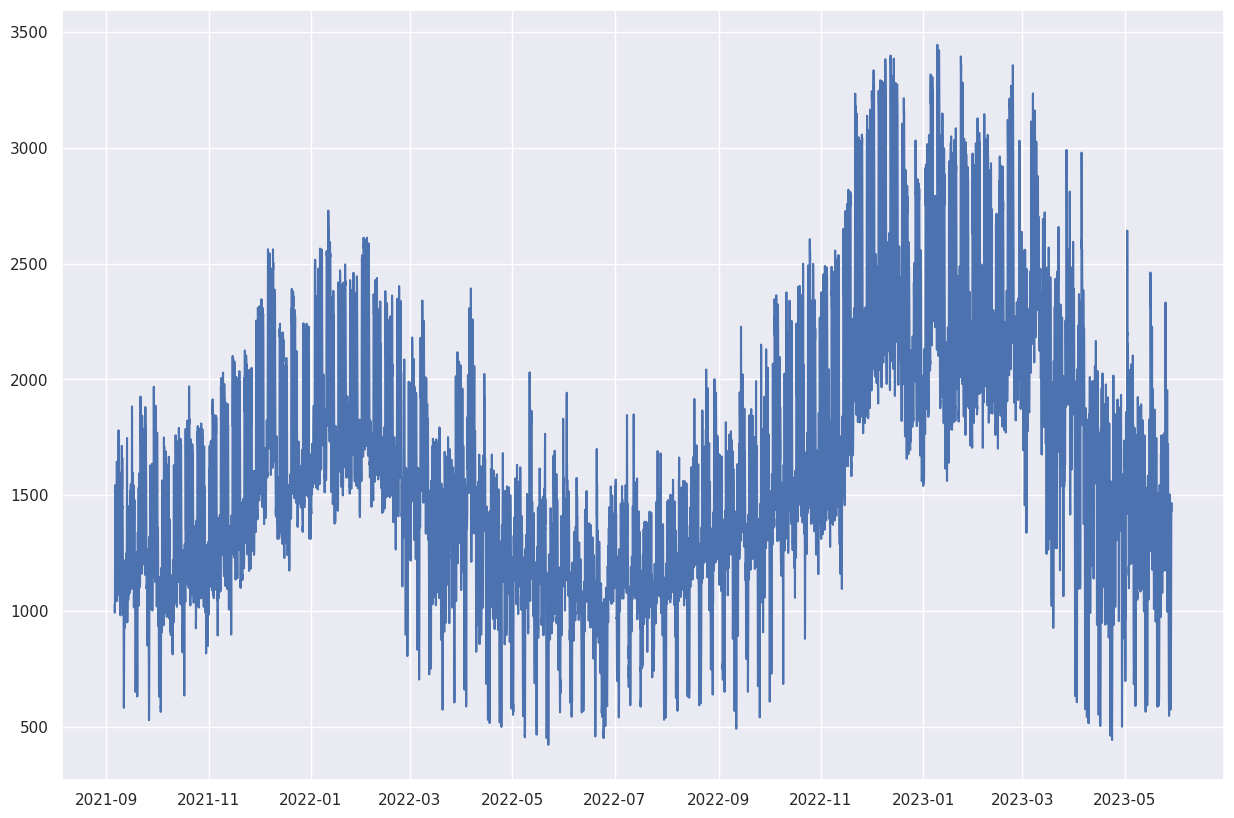

In [46]:
plt.figure(figsize=(15,10))
plt.plot(dataset["target"])

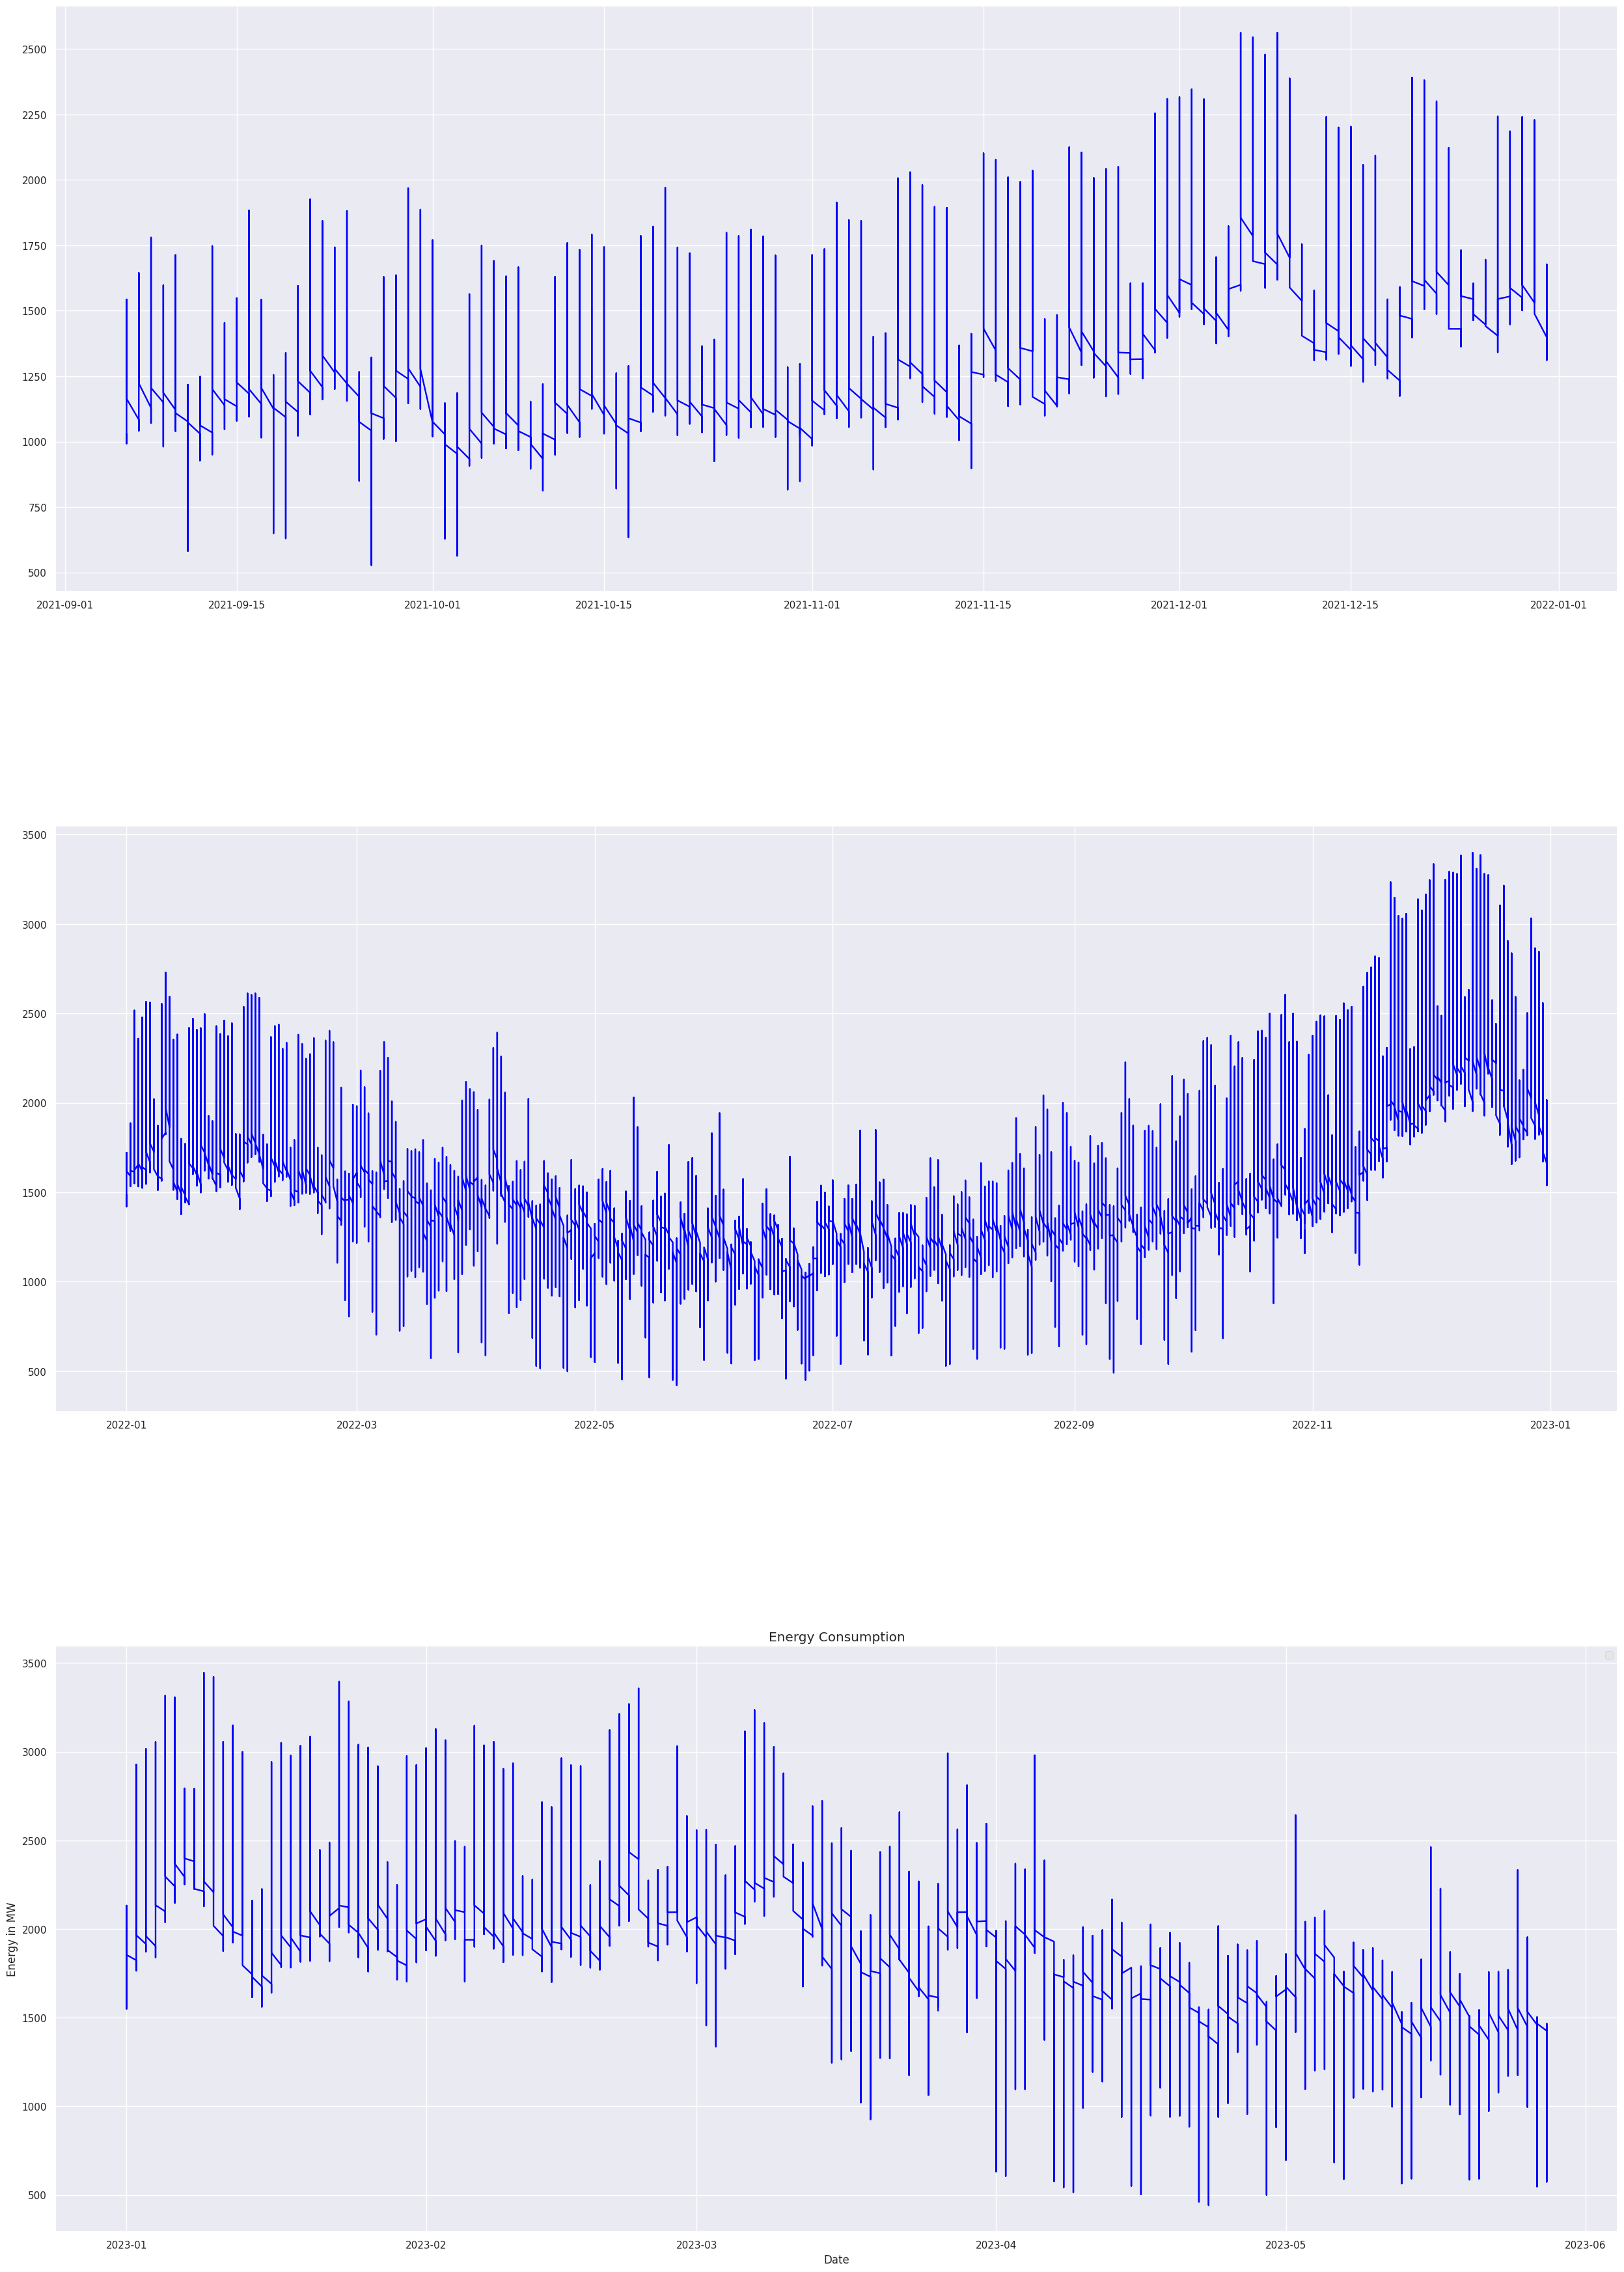

In [47]:
# Energy Consumption Each Year
from matplotlib import style

fig = plt.figure(figsize = (30,30))

ax1 = fig.add_subplot(611)
ax2 = fig.add_subplot(612)
ax3 = fig.add_subplot(613)

style.use("ggplot")

y_2016 = dataset.loc["2021"]["target"].to_list()
x_2016 = dataset.loc["2021"]["Date"].to_list()
ax1.plot(x_2016, y_2016, color= "blue", linewidth= 1.7)

y_2017 = dataset.loc["2022"]["target"].to_list()
x_2017 = dataset.loc["2022"]["Date"].to_list()
ax2.plot(x_2017, y_2017, color= "blue", linewidth= 1.7)

y_2018 = dataset.loc["2023"]["target"].to_list()
x_2018 = dataset.loc["2023"]["Date"].to_list()
ax3.plot(x_2018, y_2018, color= "blue", linewidth= 1.7)

plt.rcParams["figure.figsize"] = (30, 15)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=2.5, wspace=0.4, hspace=0.4)
plt.title("Energy Consumption")
plt.xlabel("Date")
plt.ylabel("Energy in MW")
plt.grid(True, alpha=1)
plt.legend()

/tmp/ipykernel_42/3821144039.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset["target"])


Text(0.5, 1.0, 'Energy Distribution')

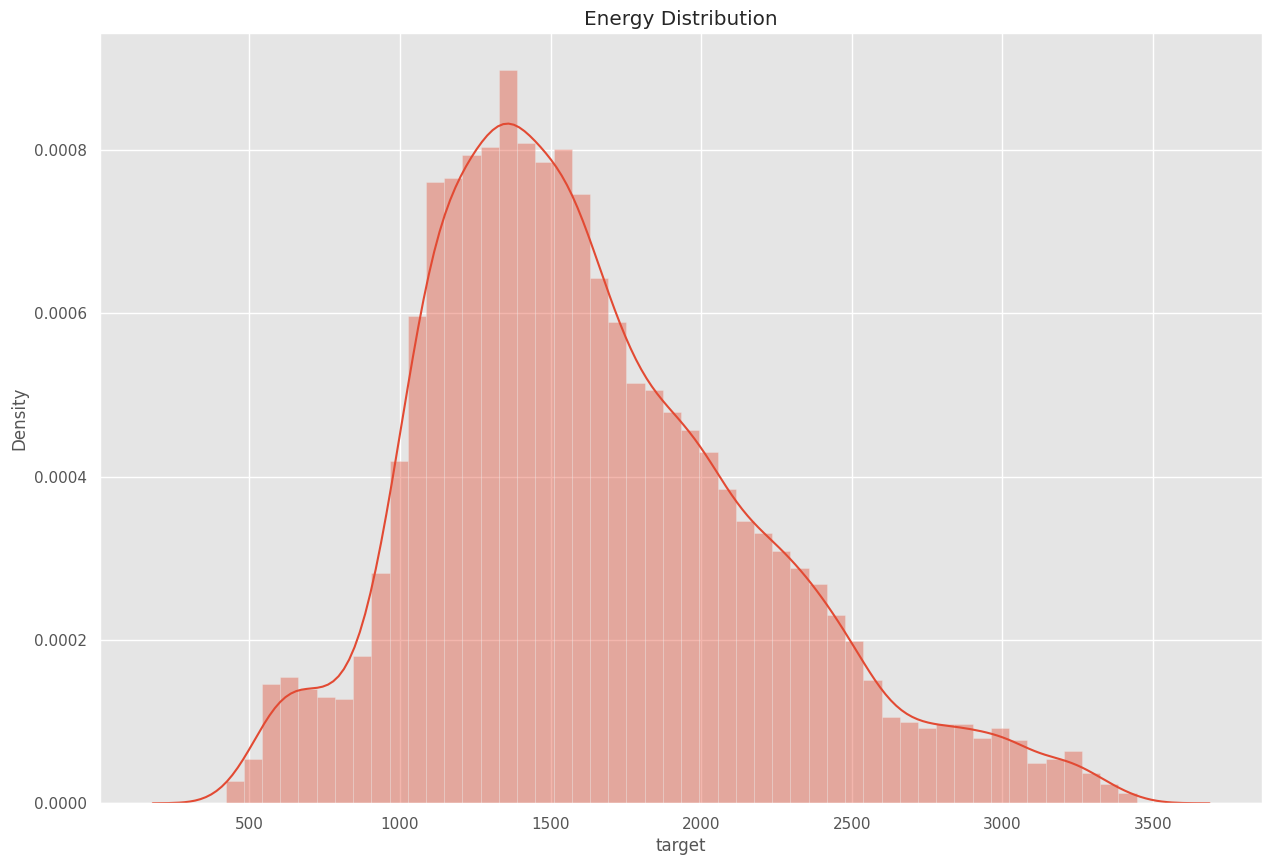

In [48]:

# Lets us see the Distribution off Energy Consumption so we have a idea about your Dataset a bit more
fig = plt.figure(figsize = (15,10))
sns.distplot(dataset["target"])
plt.title("Energy Distribution")

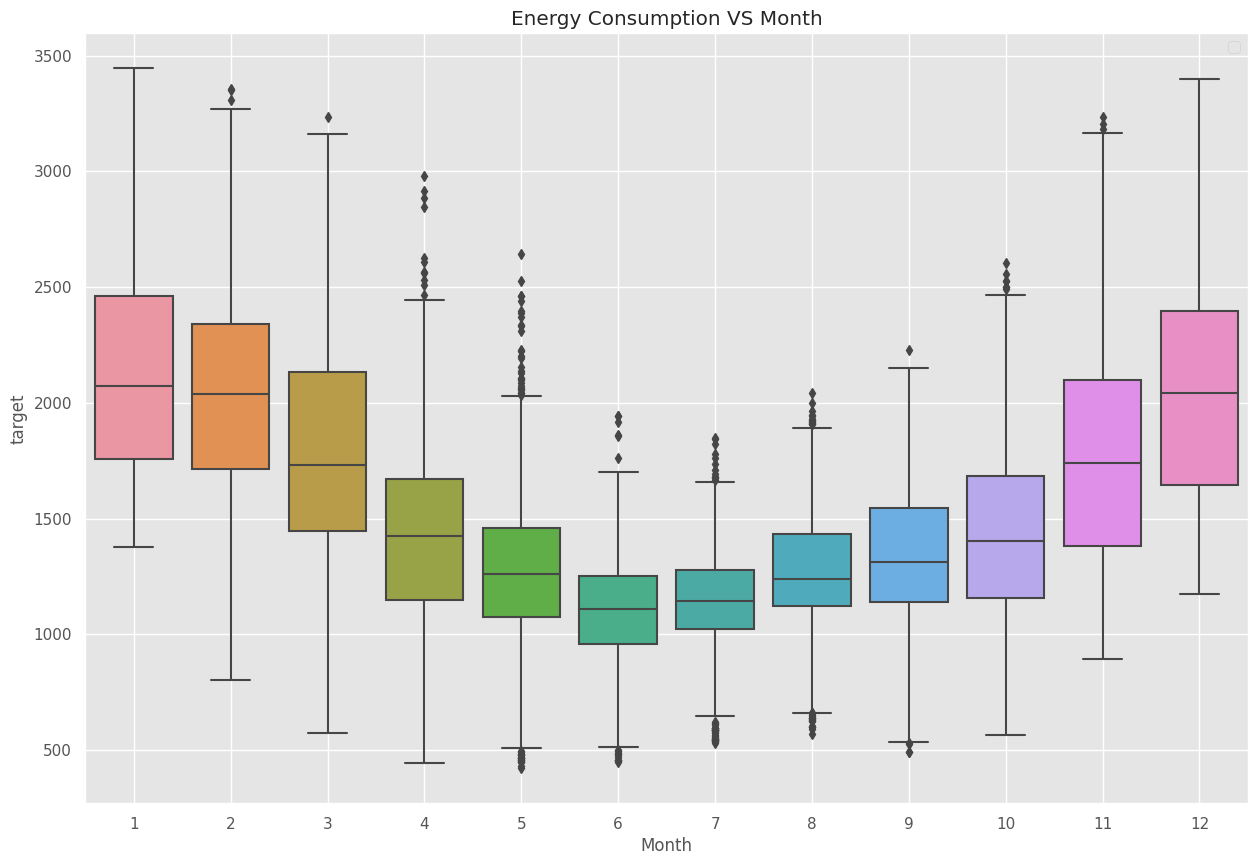

In [49]:

fig = plt.figure(figsize = (15,10))
sns.boxplot(x=dataset["Month"], y=dataset["target"], data= dataset)
plt.title("Energy Consumption VS Month")
plt.xlabel("Month")
plt.grid(True, alpha=1)
plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)

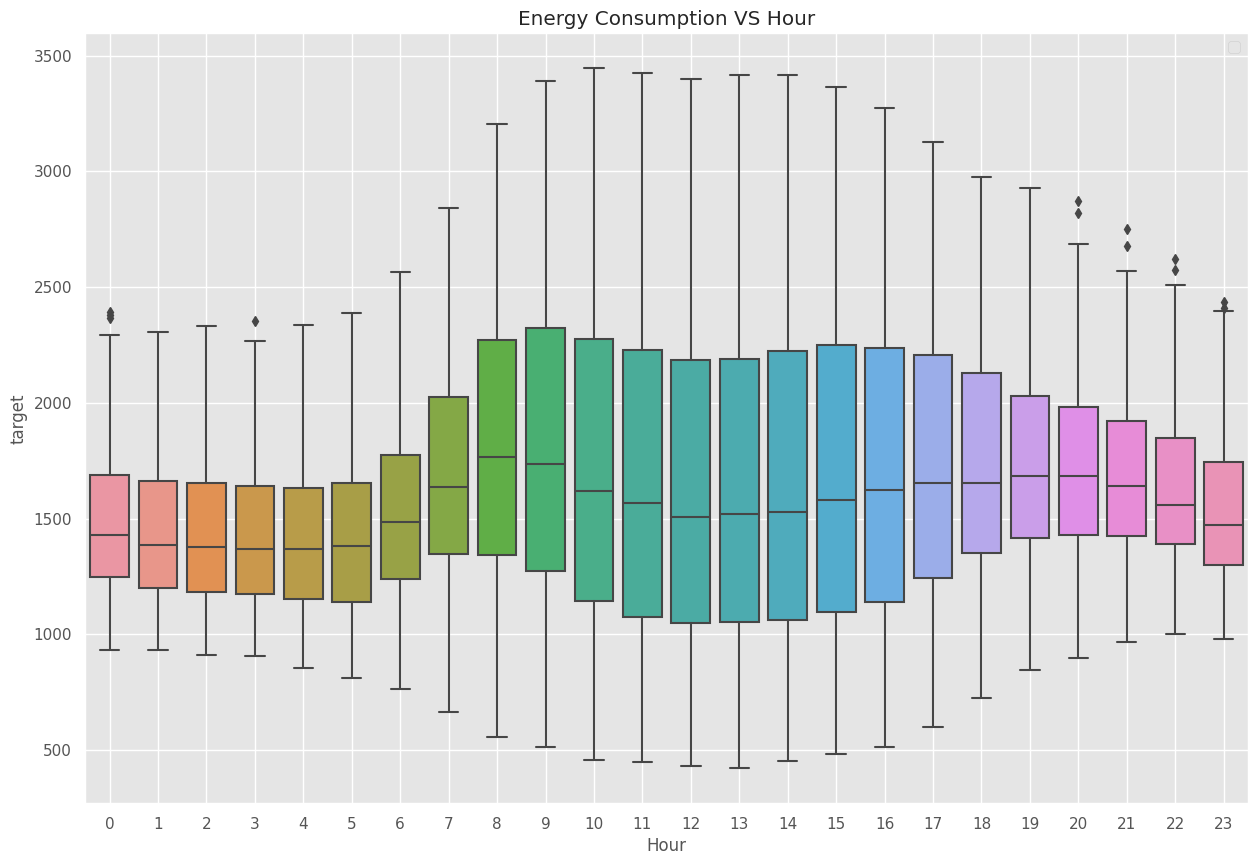

In [50]:
dataset1 = dataset
fig = plt.figure(figsize = (15,10))
sns.boxplot(x=dataset1.index.hour, y=dataset1.target, data= dataset)
plt.title("Energy Consumption VS Hour")
plt.xlabel("Hour")
plt.grid(True, alpha=1)
plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)

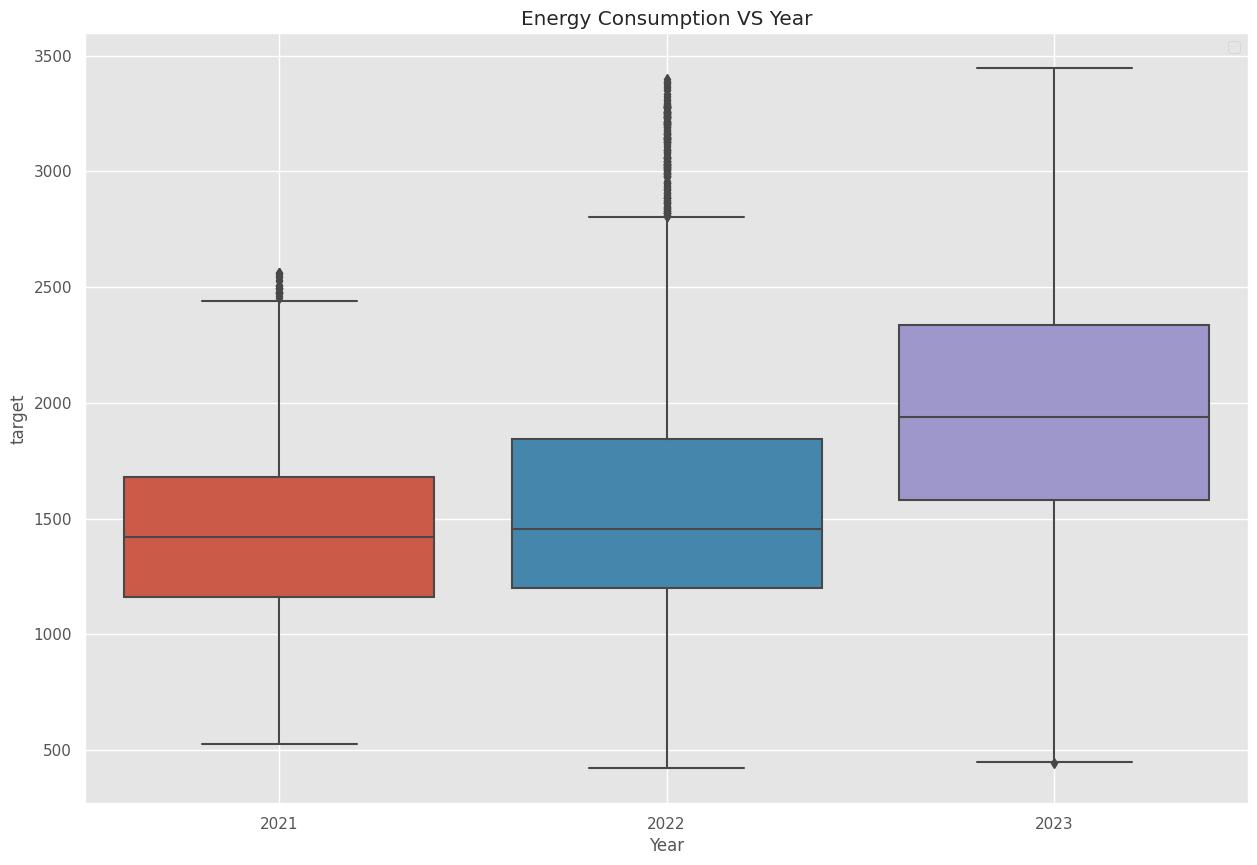

In [51]:

fig = plt.figure(figsize = (15,10))
sns.boxplot(x=dataset1.index.year, y=dataset1.target, data= dataset)
plt.title("Energy Consumption VS Year")
plt.xlabel("Year")
plt.grid(True, alpha=1)
plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)

In [52]:
# Downsampling involves decreasing the time-frequency of the data
# Downsapling the time-frequency from hours to days 
dataset = dataset.drop(['Time', 'Day', 'Date'], axis=1)
print(dataset)
newDataSet = dataset.resample("D").mean()
print(newDataSet)

                          target  Month  Year  Week
datetime                                           
2021-09-06 01:00:00  1028.872000      9  2021    36
2021-09-06 02:00:00  1000.634833      9  2021    36
2021-09-06 03:00:00   992.329333      9  2021    36
2021-09-06 04:00:00  1010.400833      9  2021    36
2021-09-06 05:00:00  1013.827000      9  2021    36
...                          ...    ...   ...   ...
2023-05-28 19:00:00  1310.162714      5  2023    21
2023-05-28 20:00:00  1384.132857      5  2023    21
2023-05-28 21:00:00  1433.445286      5  2023    21
2023-05-28 22:00:00  1466.209429      5  2023    21
2023-05-28 23:00:00  1428.327143      5  2023    21

[15119 rows x 4 columns]
                 target  Month    Year  Week
datetime                                    
2021-09-06  1257.360790    9.0  2021.0  36.0
2021-09-07  1304.345632    9.0  2021.0  36.0
2021-09-08  1424.701833    9.0  2021.0  36.0
2021-09-09  1217.544542    9.0  2021.0  36.0
2021-09-10  1378.657681    9

In [53]:
# We have 2193 row
# 2193 - 3 - 6 = 2184 row after omit first two rows and last six ones.  
# 2184 / 7 = 312 week  
# 312 * 80 %  250 week for train (1750 day)  
# 312 - 250 = 62 week for test (434 day)
print("Old Dataset: ", dataset.shape)
print("New Dataset: ", newDataSet.shape)

Old Dataset:  (15119, 4)
New Dataset:  (630, 4)


In [54]:
newDataSet.head()


,target,Month,Year,Week
datetime,,,,
2021-09-06,1257.360790,9.0,2021.0,36.0
2021-09-07,1304.345632,9.0,2021.0,36.0
2021-09-08,1424.701833,9.0,2021.0,36.0
2021-09-09,1217.544542,9.0,2021.0,36.0
2021-09-10,1378.657681,9.0,2021.0,36.0


In [55]:
y = newDataSet["target"]
print(y[0])
y.shape

1257.3607898550724


(630,)

In [56]:
# Normalize data before model fitting
# it will boost the performance( in neural networks) + transform
from sklearn.preprocessing import MinMaxScaler
# scale of the output and input inthe range 0-1 to match the scale of the layer of LSTM
scaler = MinMaxScaler(feature_range = (0,1)) 
# reshape: convert the univariate 1D array into 2D
y = scaler.fit_transform(np.array(y).reshape(-1,1))
print("Normalizing data before model fitting")
print(y[:10])

Normalizing data before model fitting
[[0.25195887]
 [0.2748145 ]
 [0.33336139]
 [0.23259039]
 [0.31096336]
 [0.09878796]
 [0.15327725]
 [0.2493328 ]
 [0.24029746]
 [0.29167115]]


In [57]:
training_size = int(len(y)*0.80)
val_size = int(len(y)*0.90)
train_data = y[0:training_size,:]
val_data = y[training_size:val_size,:]
test_data = y[val_size:,:]


In [58]:
# building input variable
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [] , []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i + time_step,0])
    return np.array(dataX), np.array(dataY)

In [59]:
time_step = 2
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
X_val, yval = create_dataset(val_data, time_step)


In [60]:
# reshape train and input-output pairs
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1],1)

print("X_train shape: ", X_train.shape)
print("X_test shape: ",X_test.shape)
print("X_val shape: ",X_val.shape)

X_train shape:  (501, 2, 1)
X_test shape:  (60, 2, 1)
X_val shape:  (60, 2, 1)


In [61]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (time_step, 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

# # Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
# model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mse')

In [62]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 2, 50)             10400     
                                                                 
 dropout_1 (Dropout)         (None, 2, 50)             0         
                                                                 
 lstm_5 (LSTM)               (None, 2, 50)             20200     
                                                                 
 lstm_6 (LSTM)               (None, 2, 50)             20200     
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71051 (277.54 KB)
Trainable params: 7105

In [63]:
history = model.fit(X_train, y_train, validation_data = (X_val,yval), verbose = 1,epochs = 60 ,batch_size = 20)


Epoch 1/60
26/26 [==============================] - 10s 75ms/step - loss: 0.1448 - val_loss: 0.1312
Epoch 2/60
26/26 [==============================] - 0s 10ms/step - loss: 0.0424 - val_loss: 0.0860
Epoch 3/60
26/26 [==============================] - 0s 11ms/step - loss: 0.0292 - val_loss: 0.0326
Epoch 4/60
26/26 [==============================] - 0s 14ms/step - loss: 0.0181 - val_loss: 0.0232
Epoch 5/60
26/26 [==============================] - 0s 11ms/step - loss: 0.0201 - val_loss: 0.0180
Epoch 6/60
26/26 [==============================] - 0s 10ms/step - loss: 0.0169 - val_loss: 0.0219
Epoch 7/60
26/26 [==============================] - 0s 11ms/step - loss: 0.0167 - val_loss: 0.0254
Epoch 8/60
26/26 [==============================] - 0s 11ms/step - loss: 0.0164 - val_loss: 0.0195
Epoch 9/60
26/26 [==============================] - 0s 11ms/step - loss: 0.0162 - val_loss: 0.0184
Epoch 10/60
26/26 [==============================] - 0s 11ms/step - loss: 0.0161 - val_loss: 0.0186
Epoch 11

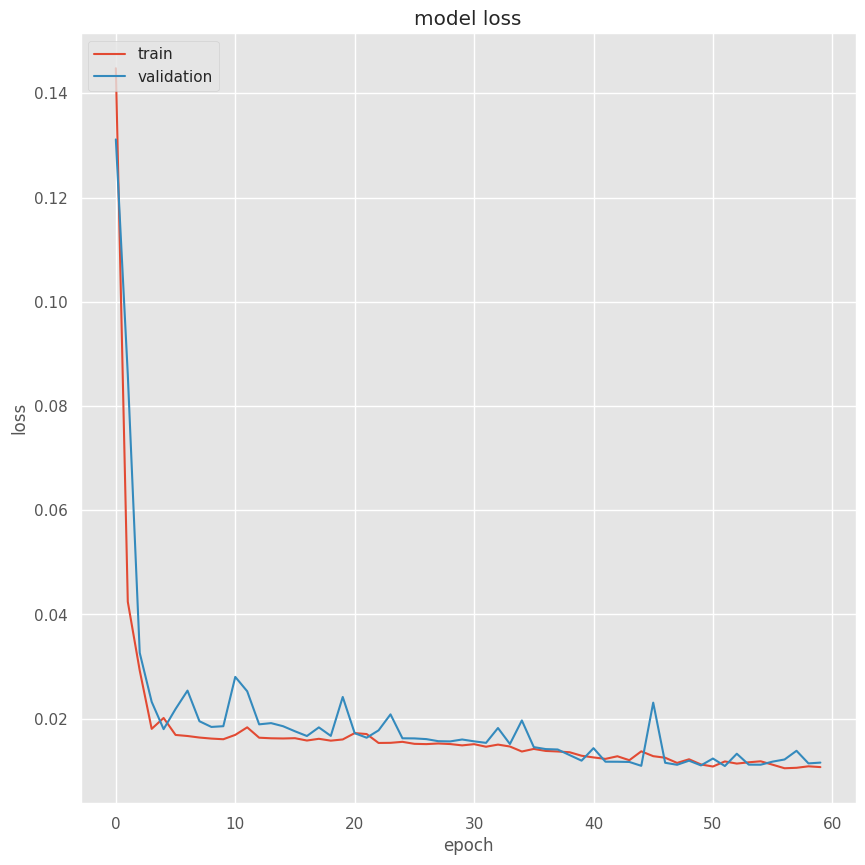

In [64]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss']) # tb
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [65]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
val_predict=model.predict(X_test)

2/2 [==============================] - 0s 7ms/step


In [66]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
val_predict=scaler.inverse_transform(val_predict)
     

In [67]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

1619.232555848157

In [68]:
print(train_predict.shape)
print(test_predict.shape)
print(val_predict.shape)
print(train_predict[0])
print(y_train.shape)


(501, 1)
(60, 1)
(60, 1)
[1328.8477]
(501,)


In [69]:
# Predicting consumption using training data
train_predictions = model.predict(X_train)
train_predictions =scaler.inverse_transform(train_predictions)

y_train = y_train.reshape(y_train.shape[0], 1)
actual = scaler.inverse_transform(y_train)
train_results = pd.DataFrame()

train_results["Train Predictions"] = train_predictions.tolist()
train_results["Actuals"] = actual.tolist()

train_results

16/16 [==============================] - 0s 4ms/step


,Train Predictions,Actuals
0,[1328.84765625],[1424.7018333333333]
1,[1420.3746337890625],[1217.5445416666666]
2,[1278.1048583984375],[1378.6576805555558]
3,[1379.32568359375],[942.4837777777778]
4,[1097.08203125],[1054.4986944444445]
...,...,...
496,[2268.753173828125],[2462.240714285714]
497,[2401.06640625],[2390.229553571429]
498,[2307.52587890625],[2447.8774761904765]
499,[2379.6201171875],[2490.4143452380954]


In [70]:
plt.figure(figsize=(20,10))

# Actual Consumption
ActualPlot = np.empty_like(y )
ActualPlot[:, :] = np.nan
ActualPlot[88:, :] = actual.tolist()
plt.plot(ActualPlot)

TrainPredictionsPlot = np.empty_like(y )
TrainPredictionsPlot[:, :] = np.nan
TrainPredictionsPlot[887:, :] = train_predictions.tolist()
plt.plot(TrainPredictionsPlot)

plt.legend(['actual','train_predictions'])
plt.xlabel('Time Steps')
plt.ylabel('Consumption MWh')
plt.show()

ValueError: could not broadcast input array from shape (501,1) into shape (542,1)

<Figure size 2000x1000 with 0 Axes>

In [ ]:
# Predicting consumption using validation data
val_predictions = model.predict(X_val)
val_predictions =scaler.inverse_transform(val_predictions)

yval = yval.reshape(yval.shape[0], 1)
actual_val = scaler.inverse_transform(yval)

val_results = pd.DataFrame()
val_results["Val Predictions"] = val_predictions.tolist()
val_results["Actuals_val"] = actual_val.tolist()

val_results

In [ ]:
plt.figure(figsize=(20,10))

# Actual Consumption
ActualPlot = np.empty_like(y)
ActualPlot[:, :] = np.nan
ActualPlot[1936:, :] = actual_val.tolist()
plt.plot(ActualPlot)

# Validation Prediction
ValPredictionsPlot = np.empty_like(y)
ValPredictionsPlot[:, :] = np.nan
ValPredictionsPlot[1936:, :] = val_predictions.tolist()
plt.plot(ValPredictionsPlot)

plt.legend(['actual_val','Val_predictions'])
plt.xlabel('Time Steps')
plt.ylabel('Consumption MWh')

In [ ]:
# Predicting consumption using test data
test_predictions = model.predict(X_test)
test_predictions =scaler.inverse_transform(test_predictions)

ytest = ytest.reshape(ytest.shape[0], 1)
actual_test = scaler.inverse_transform(ytest)

test_results = pd.DataFrame()
test_results["test Predictions"] = test_predictions.tolist()
test_results["Actuals_test"] = actual_test.tolist()

test_results

In [ ]:
plt.figure(figsize=(20,10))

# Actual Consumption
ActualPlot = np.empty_like(y)
ActualPlot[:, :] = np.nan
ActualPlot[1848:, :] = actual_test.tolist()
plt.plot(ActualPlot)

# Test Prediction
TestPredictionsPlot = np.empty_like(y)
TestPredictionsPlot[:, :] = np.nan
TestPredictionsPlot[1848:, :] = test_predictions.tolist()
plt.plot(TestPredictionsPlot)

plt.legend(['Actual_test','Test_predictions'])
plt.xlabel('Time Steps')
plt.ylabel('Consumption MWh')

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=100 #*****************************************>>>>>100
fig, ax = plt.subplots(figsize=(20,10))
trainPredictPlot = np.empty_like(y)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(y)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1+349:len(y)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(y))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['inverse_transform(y)','trainPredictPlot','testPredictPlot'])
plt.xlabel('Time Steps')
plt.ylabel('Consumption MWh')
plt.show()

In [ ]:
print(len(test_data))
print(test_data[0])
print(len(train_data))
x_input=test_data[337:].reshape(1,-1)
print(x_input.shape)
# print(x_input[0])
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
# print(temp_input)

In [ ]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
test = ""
while(i<30):
    
    if(len(temp_input)>100):
        test = "if"
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        test="else"
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

    
print(test)
print(len(lst_output))

In [ ]:
print(len(y))
day_new=np.arange(1,101)
day_pred=np.arange(101, 131 )
plt.figure(figsize = (15,10))
plt.plot(day_new,scaler.inverse_transform(y[2084:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))
print(scaler.inverse_transform(lst_output))

In [ ]:
df3=y.tolist()
df3.extend(lst_output)
plt.figure(figsize=(15,10))
plt.plot(df3[2000:])


In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
arima_model = ARIMA